# Import thư viện


In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Loading Data

In [4]:
df=pd.read_csv("../data/TabularPlayground-July2022/data.csv")
df=df.drop("id",axis=1)
ss=pd.read_csv("../data/TabularPlayground-July2022/sample_submission.csv")

# Let's Look at correlation Heat Map¶

<Axes: >

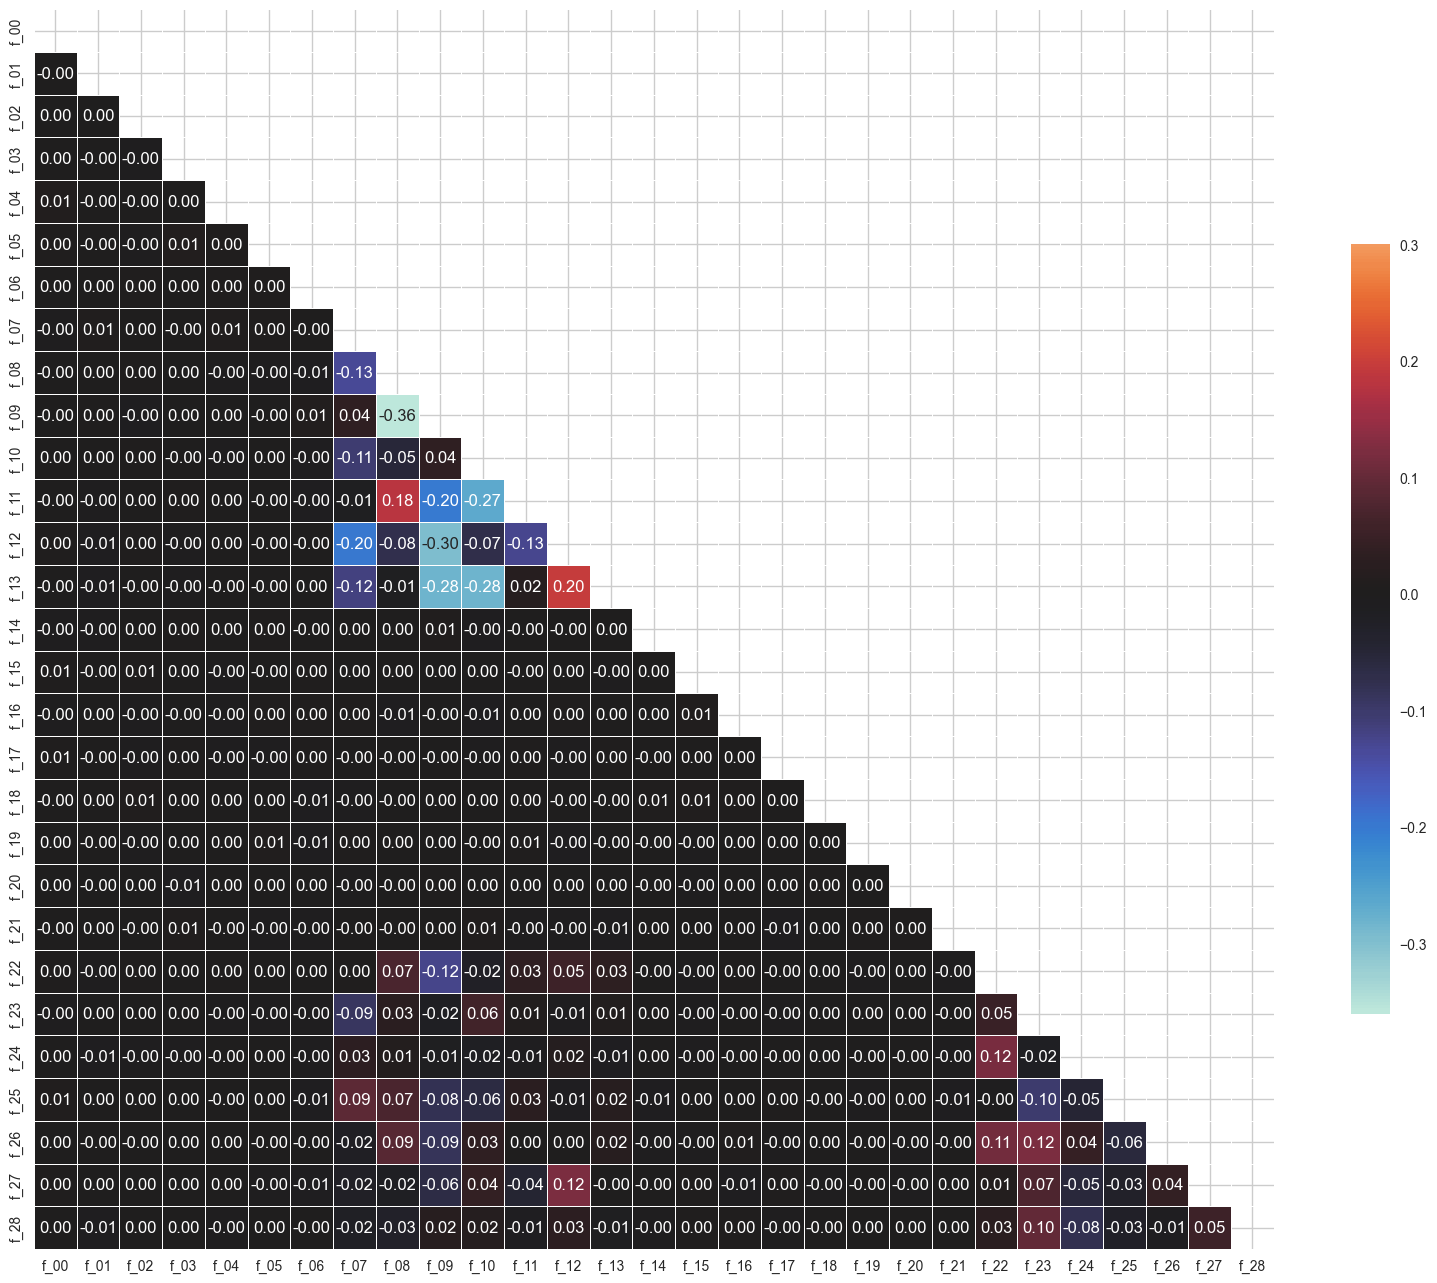

In [5]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,fmt='.2f')

# Feature Selection

In [6]:
feats= ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']

# Preprocessing Data

In [7]:
transformer = PowerTransformer()
X=transformer.fit_transform(df[feats])

# Dimensionality Reduction

In [8]:
pca = PCA(n_components=3,random_state=1)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(df[feats]), columns=(["col1","col2","col3"]))
PCA_ds.describe().T

count      mean       std        min       25%       50%       75%  \
col1  98000.0 -1.846882  6.183381 -21.181599 -6.112243 -2.777183  1.774114   
col2  98000.0 -1.322841  4.183491 -17.967360 -4.296643 -1.625981  1.480935   
col3  98000.0 -1.109548  4.178339 -17.550269 -3.979848 -1.173112  1.677173   

            max  
col1  27.772016  
col2  16.055424  
col3  15.872467

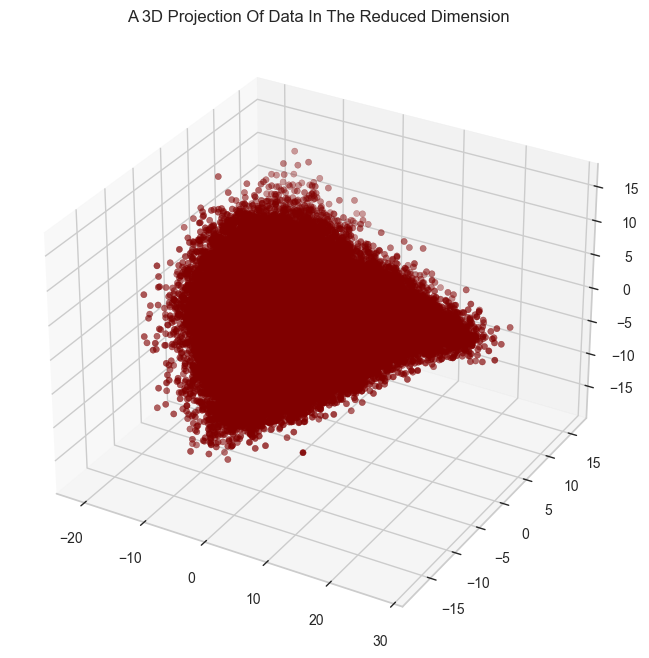

In [9]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Elbow Method to determine optimum number of clusters to be formed:
    - 7 clusters gives the best results on leaderboard.

Elbow Method to determine the number of clusters to be formed:


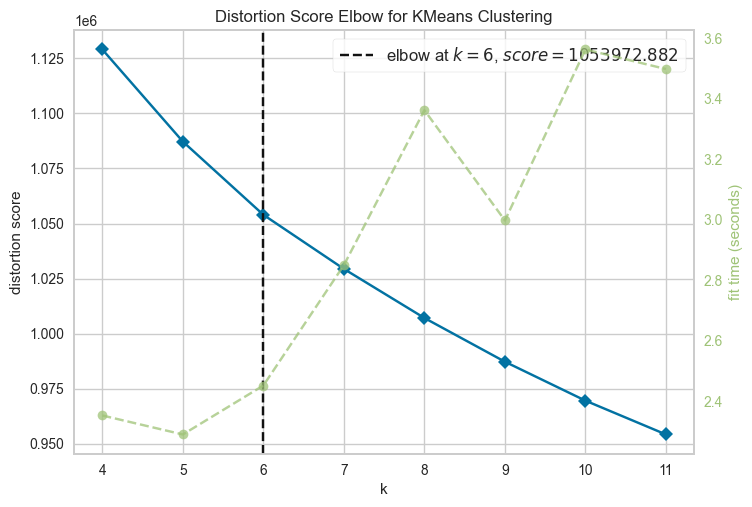

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(4,12))
Elbow_M.fit(X)
Elbow_M.show()

# Bayesian Gaussian Mixture

In [11]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
PCA_ds["Clusters"] = preds
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

KeyboardInterrupt: 

In [12]:
BGM = BayesianGaussianMixture(n_components=7, covariance_type='diag', random_state=1, n_init=5, verbose=2)
preds = BGM.fit_predict(X)
PCA_ds["Clusters"] = preds
df["Clusters"] = preds

Initialization 0
  Iteration 10	 time lapse 1.51872s	 ll change 177.86215
  Iteration 20	 time lapse 0.90788s	 ll change 16.61697
  Iteration 30	 time lapse 0.92446s	 ll change 1.58525
  Iteration 40	 time lapse 0.92587s	 ll change 0.24325
  Iteration 50	 time lapse 1.00891s	 ll change 0.07698
  Iteration 60	 time lapse 0.97056s	 ll change 0.03603
  Iteration 70	 time lapse 0.91437s	 ll change 0.01875
  Iteration 80	 time lapse 0.91340s	 ll change 0.01001
  Iteration 90	 time lapse 0.91889s	 ll change 0.00540
  Iteration 100	 time lapse 0.91143s	 ll change 0.00292
Initialization converged: False	 time lapse 9.91449s	 ll -618233.34550
Initialization 1
  Iteration 10	 time lapse 1.30792s	 ll change 593.02506
  Iteration 20	 time lapse 0.87473s	 ll change 254.97623
  Iteration 30	 time lapse 0.83469s	 ll change 27.12532
  Iteration 40	 time lapse 0.86084s	 ll change 5.08756
  Iteration 50	 time lapse 0.87481s	 ll change 2.51318
  Iteration 60	 time lapse 0.86737s	 ll change 1.91967
  Iter

# Creating a classifier

In [13]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [14]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 0.0135884
[400]	valid_0's multi_logloss: 0.00565291
[600]	valid_0's multi_logloss: 0.00414535
[800]	valid_0's multi_logloss: 0.00380961
[1000]	valid_0's multi_logloss: 0.00372788
[200]	valid_0's multi_logloss: 0.0179748
[400]	valid_0's multi_logloss: 0.00985004
[600]	valid_0's multi_logloss: 0.00878087
[800]	valid_0's multi_logloss: 0.00829124
[1000]	valid_0's multi_logloss: 0.00820225
[1200]	valid_0's multi_logloss: 0.00839316
[200]	valid_0's multi_logloss: 0.0160236
[400]	valid_0's multi_logloss: 0.00777907
[600]	valid_0's multi_logloss: 0.00700239
[800]	valid_0's multi_logloss: 0.00747573
[200]	valid_0's multi_logloss: 0.0154012
[400]	valid_0's multi_logloss: 0.00738907
[600]	valid_0's multi_logloss: 0.00573328
[800]	valid_0's multi_logloss: 0.0051662
[1000]	valid_0's multi_logloss: 0.00507616
[1200]	valid_0's multi_logloss: 0.00500758
[1400]	valid_0's multi_logloss: 0.00499262
[200]	valid_0's multi_logloss: 0.0171275
[400]	valid_0's multi_logloss: 0.0

In [15]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [16]:
labels=np.argmax(lgb_preds,axis=1)

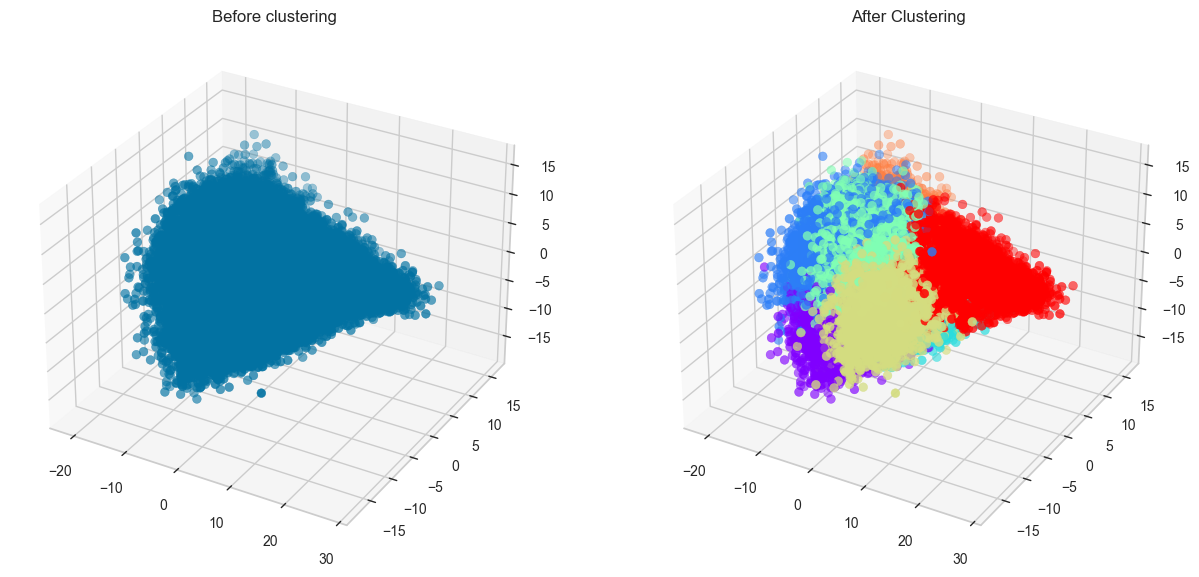

In [17]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'],PCA_ds['col2'],PCA_ds['col3'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'],PCA_ds['col2'],PCA_ds['col3'], s=40, c=PCA_ds["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

In [18]:
ss.Predicted=np.argmax(lgb_preds,axis=1)

# Ploting the count plot for cluster distribution

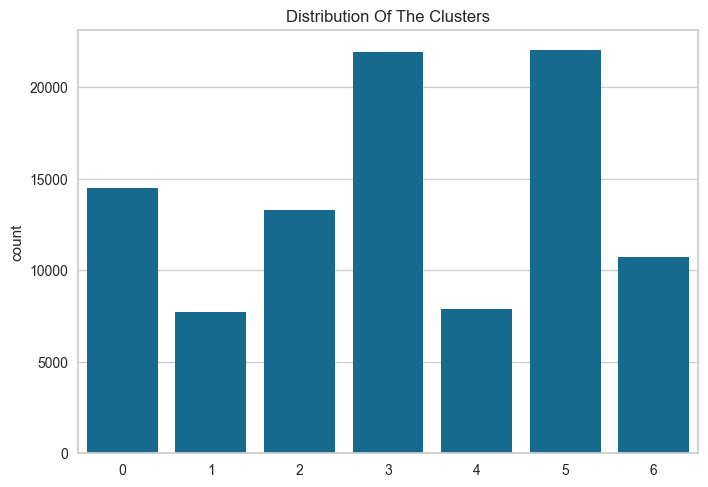

In [19]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

In [20]:
ss.to_csv("submission.csv",index=False)